In [1]:
!pip install pyro-ppl

In [2]:
import torch 
import pyro

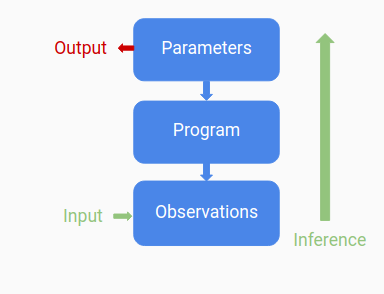

# Stochastic Functions

* Basic units of probabilistic programs

Made up of two parts:

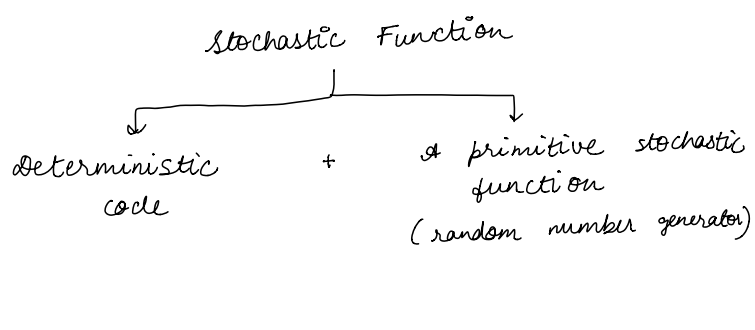

In [3]:
# A primitive stochastic function in Pytorch

beta = torch.distributions.Beta(10.,10.) # create a Beta distribution object
x = beta.rsample() # draw a sample

print("sample: ",x)
print("log probability: ", beta.log_prob(x)) #score sample from Beta(10,10)

sample:  tensor(0.6553)
log probability:  tensor(0.3464)


### So what's different in Pyro?

Make following replacements:

- Replace **torch.distributions** with **pyro.distributions** (thin wrapper which enables naming of samples)
- Replace **.sample() or .rsample()** with **pyro.sample**

Pyro's sample method comes with many bells and whistles suited for running inferences (covered later)

In [4]:
x = pyro.sample("pyro_beta_sample", pyro.distributions.Beta(10., 10.))
print("sample: ",x)

sample:  tensor(0.4982)


### A stochastic function example

Let's write a function to sample whether a person is a senior citizen and the risk to their life on getting COVID-19 in Canada.   

- Age data take from here: https://www150.statcan.gc.ca/n1/pub/91-215-x/2014000/part-partie2-eng.htm 
- COVID-19 data taken from here: https://health-infobase.canada.ca/covid-19/epidemiological-summary-covid-19-cases.html

In [5]:
def at_risk():
    
    senior = pyro.sample('senior', pyro.distributions.Bernoulli(0.15)) # chance of being a senior citizen
    senior = 'senior' if senior.item() == 1.0 else 'not_senior'
    
    mean_risk = {'senior': 50.0, 'not_senior': 5.0}[senior] # on a scale of 100
    scale_risk = {'senior': 1.0, 'not_senior': 1.0}[senior]
    
    risk = pyro.sample('risk', pyro.distributions.Normal(mean_risk, scale_risk))
    
    return senior, risk

In [6]:
# Let's check our samples

for _ in range(5):
    print(at_risk())

('not_senior', tensor(6.6860))
('not_senior', tensor(4.9147))
('senior', tensor(50.6343))
('not_senior', tensor(5.9921))
('not_senior', tensor(5.6681))


## From stochastic functions to probabilistic programs

### Modularity 

In [7]:
def action_on_symptoms(num_days):
    senior, risk = at_risk()
    
    if senior == 'senior' and risk > 50:
        return senior, 'check-in'
    elif senior != 'senior' and num_days < 14:
        return senior, 'self-isolate'
    else:
        return senior, 'inform_authorities'

In [8]:
for i in range(20):
    print(i, action_on_symptoms(i))

0 ('not_senior', 'self-isolate')
1 ('senior', 'inform_authorities')
2 ('not_senior', 'self-isolate')
3 ('not_senior', 'self-isolate')
4 ('senior', 'check-in')
5 ('not_senior', 'self-isolate')
6 ('not_senior', 'self-isolate')
7 ('not_senior', 'self-isolate')
8 ('not_senior', 'self-isolate')
9 ('not_senior', 'self-isolate')
10 ('not_senior', 'self-isolate')
11 ('senior', 'inform_authorities')
12 ('not_senior', 'self-isolate')
13 ('not_senior', 'self-isolate')
14 ('not_senior', 'inform_authorities')
15 ('not_senior', 'inform_authorities')
16 ('not_senior', 'inform_authorities')
17 ('not_senior', 'inform_authorities')
18 ('senior', 'inform_authorities')
19 ('senior', 'inform_authorities')


### Random control flow (demonstrated above)

### Higher order stochastic functions

Inputs and/or Outputs are other stochastic functions

In [9]:
def expected_hospitalization_duration(loc, scale):
    # Samples expected hospitalization from a normal of given mean and variance
    avg_hospitalization = pyro.sample("avg_time", pyro.distributions.Normal(loc, scale))
    return avg_hospitalization

def get_duration(risk_function): # takes as input the risk function 
    senior, risk = risk_function()
    print(risk)
    
    # fn is a python function which takes as input mean, adds the risk to it to get mean for the particular person
    # and then samples expected hospitalization from the function above
    fn = lambda mean: expected_hospitalization_duration(risk+mean, 1.)
    return fn

In [10]:
print(get_duration(at_risk)(10.))

tensor(3.6512)
tensor(13.5932)


Iteration/Recursion/Higher-order functions/Random control flow: Pyro stochastic functions are universal can be used to represent any probability distribution